In [1]:
from alpaca_farm.models import reward_model
from alpaca_farm.inference.decode import load_model_and_tokenizer_for_inference 
from alpaca_farm.inference.score import score_sequences_with_huggingface_given_model
from alpaca_farm import utils
import pandas as pd
from statistics import mean, stdev
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

/home/prasann/miniconda3/envs/apfarmenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
model, tokenizer = load_model_and_tokenizer_for_inference(
    model_name_or_path="/mnt/data1/prasann/prefixdecoding/tfr-decoding/apfarm_models/reward-model-human/",
    model_cls=reward_model.RewardModel,
    cache_dir=None,
    model_kwargs=dict(
        torch_dtype=utils.convert_str_dtype_to_torch_dtype(None),
        flash_attn=False,
    ),
)

Loading model for inference: /mnt/data1/prasann/prefixdecoding/tfr-decoding/apfarm_models/reward-model-human/
One of the `_name_or_path` to the root node is not a pretrained model name or local path on disk. This may be due to copying checkpoints across machines. Falling back to hardcoded rule to figure out the pretrained model based on config.json.
Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.02s/it]


In [51]:
ppoouts.keys()

Index(['instruction', 'output', 'top_sequence', 'top_index', 'top_scores'], dtype='object')

In [7]:
ppoouts = pd.read_json("alpaca_farm/bon_outs/ppohum.jsonl", orient="records").drop(columns=['input', 'scorer_name_or_path'])
sftouts = pd.read_json("alpaca_farm/bon_outs/sft.jsonl", orient="records").drop(columns=['input', 'scorer_name_or_path'])


In [62]:
def scoreseq(inp, ans):
    # TODO make a batched version if necessary
    template = "Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:{response}"
    seq = template.format(instruction=inp, response=ans)
    return score_sequences_with_huggingface_given_model(model, tokenizer, [seq], per_device_batch_size=1)
    

In [68]:
inp = ppoouts.loc[1]['instruction']
hyp = ppoouts.loc[1]['output'][1]
scoreseq(inp, hyp)

Unknown mixed precision mode: None, falling back to fp32.
mixed_precision = None


getting rewards


evaluating rewards for batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


[1.6832951307296753]

In [57]:
ppoouts.loc[1].top_index[0]

1

In [77]:
def printex(row):
    print(row.instruction)
    for i in [1, 2, 6, 7]:
        topind = row.top_index[i]
        print(row.top_scores[topind])
        print(row.output[topind])

In [95]:

ind = 15
print("_________")
print("BEFORE PPO")
printex(sftouts.loc[ind])
print("_________")
print("AFTER PPO")
printex(ppoouts.loc[ind])


_________
BEFORE PPO
I want to get better at networking at work
1.63993239402771
Networking is an important part of success at work, and it can be learned. Start by getting comfortable with the concept of networking and identifying your own strengths and weaknesses in this area. Research ways to build relationships with colleagues, managers and other professionals in your field. Develop a strategy for making connections, such as attending professional events or building an online presence. Identify opportunities to put your strategy into action, and practice using social media, in person events and other methods to make connections and build relationships. It may also help to find a mentor who can provide support and advice. Through consistent effort and practice, you can build your networking skills and become more successful at work.
1.541395664215088
To get better at networking at work, start by making a conscious effort to get to know your colleagues better. Introduce yourself to n

In [32]:
mean([mean(m) for m in ppoouts.top_scores])

1.5167918519955126

93.915


(array([ 56.,  77., 109.,  81.,  39.,  17.,   8.,   8.,   1.,   4.]),
 array([ 14. ,  42.7,  71.4, 100.1, 128.8, 157.5, 186.2, 214.9, 243.6,
        272.3, 301. ]),
 <BarContainer object of 10 artists>)

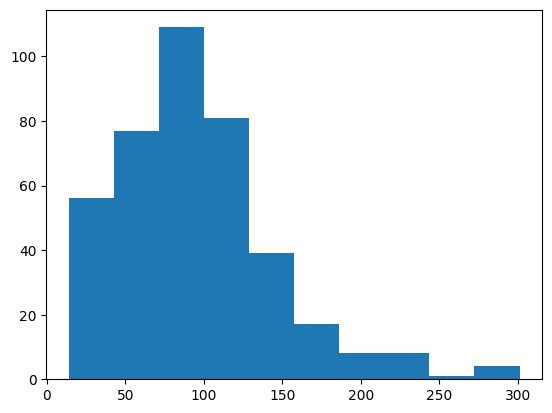

In [112]:
lendist = []
for sc in sftouts.output:
    lendist.extend([len(tokenizer(s).input_ids) for s in sc])
print(mean(lendist))
plt.hist(lendist)

(array([ 4., 22., 23., 64., 85., 86., 45., 36., 24., 11.]),
 array([-0.76558864, -0.46093694, -0.15628524,  0.14836646,  0.45301816,
         0.75766987,  1.06232157,  1.36697327,  1.67162497,  1.97627667,
         2.28092837]),
 <BarContainer object of 10 artists>)

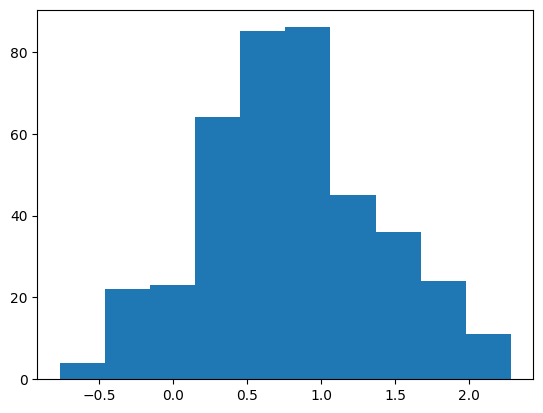

In [113]:
scodist = []
for sc in sftouts.top_scores:
    scodist.extend(sc)
plt.hist(scodist)

In [114]:
nldist = []
nsdist = []
for i in range(len(lendist)):
    if lendist[i]>=300:
        continue
    nldist.append(lendist[i])
    nsdist.append(scodist[i])

In [116]:
spearmanr(nldist, nsdist)

SignificanceResult(statistic=0.7520376811943459, pvalue=2.5054009220275723e-73)

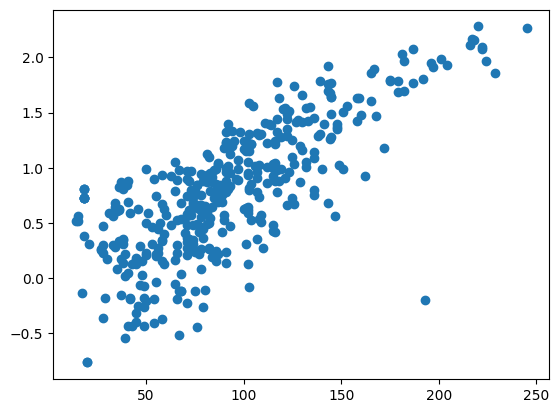

In [115]:
plt.scatter(nldist, nsdist)

In [16]:
sftouts.loc[7]['output']

['Larry Page is an American computer scientist and internet entrepreneur who is best known for co-founding Google with Sergey Brin in 1998. He is currently the CEO of Alphabet, Inc., the parent company of Google.',
 'Larry Page is an American computer scientist and businessman who is the co-founder and CEO of Google. He is also the co-founder of Alphabet, the parent company of Google. Page is a Harvard alumnus and was named the 40th richest person in the world by Forbes magazine in 2019. He is known for his strong passion for robotics, artificial intelligence, and space travel.',
 'Larry Page is an American computer scientist and entrepreneur who co-founded Google in 1998. He served as Google’s CEO from 2001 to 2011 and is currently the company’s Executive Chairman. He is also the co-founder of the spaceflight company, Planetary Ventures, and the charitable organization, Google.org.',
 "Larry Page is an American computer scientist and entrepreneur who is the co-founder of Google with S